In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os
import sys
import datetime
import matplotlib.pyplot as plt
import pyfolio as pf

sys.path.insert(0, '/mnt/afml/ml_finance/mlfinlab')
from mlfinlab.data_structures import imbalance_data_structures as imbar, standard_data_structures as bar
import mlfinlab as ml

sys.path.insert(0, '/mnt/afml/ml_finance/finance_ml')
from finance_ml import sampling, features

/mnt/afml/venv/lib/python3.5/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [2]:
def load_parq(fname):
    table = pq.read_table(fname)
    df = table.to_pandas()
    df = df.set_index('TIMESTAMP')
    ''' 중복된 index 제거, volume은 더해준다 '''
    df = df.sort_values(by='TIMESTAMP')  # 중복 데이터 무시
    df_v = df.groupby(df.index).sum()
    df = df.loc[~df.index.duplicated(keep='first')]
    df['V'] = df_v['V']
    df['DV'] = df_v['DV']
    return df

In [3]:
fname = 'dataset/TRADE_A233740_2018.parq'
df = load_parq(fname)

## Get dollar bar

In [4]:
fname = 'dataset/TRADE_A233740_2018.csv'
bar_fname = 'dataset/DBAR_A233740_2018.csv'
if not os.path.exists(fname):
    df_csv = df.reset_index()[['TIMESTAMP', 'PRICE', 'V']]
    df_csv.columns = ['date_time', 'price', 'volume']
    df_csv['price'] = df_csv['price'].astype('float')
    df_csv.to_csv(fname, index=False)
    
if os.path.exists(bar_fname):
    dbar = pd.read_csv(bar_fname, index_col='date_time')
    dbar.index = pd.to_datetime(dbar.index)
else:
    dbar = bar.get_dollar_bars(fname, threshold=1e8)
    dbar.index = pd.to_datetime(dbar.index)
    dbar.to_csv(bar_fname)

In [5]:
print(df.shape)
print(dbar.shape)

(7647271, 5)
(518545, 5)


In [6]:
def plot_bars(df, df_bar, desc='bar'):
    plt.figure(figsize = (18, 8))
    plt.title('Bars over the prices')
    plt.plot(df.index, df['PRICE'], label = 'Raw prices', color = 'blue')
    plt.plot(df_bar.index, df_bar['close'], ls = '', markersize = 5, marker = 'o', color = 'red', label = desc)
    plt.legend()
    plt.show()

In [7]:
def plot_co_events(d0, df, t_barrier_events, num_co_events, avg_uniq): 
    df0 = df.loc[d0]
    t_barrier_events0 = t_barrier_events.loc[d0]
    num_co_events0 = num_co_events.loc[d0]
    avg_uniq0 = avg_uniq.loc[d0]
    
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111)

    plt.title('Triple barriers over the prices')
    plt.plot(df0.index.values, df0.close.values, label='raw_prices', ls='--', color='black')

    # Draw barrier region 
    for i in t_barrier_events0.itertuples(): 
        try: 
            t0, t1, trgt = i.Index, i.t1, i.trgt
            t1 = min(t1, pd.Timestamp("{} 15:30".format(d0)))

            x0 = mdates.date2num(t0)
            x1 = mdates.date2num(t1)
            w = x1 - x0 

            y0 = df0.loc[t0].close * (1 - trgt)
            y1 = df0.loc[t0].close * (1 + trgt)
            h = y1 - y0

            rect = Rectangle((x0, y0), w, h, color='black', alpha=0.05)
            ax.add_patch(rect)

            df1 = df0.loc[[t0, t1]].dropna()

            plt.plot(df1.index.values, df1.close.values, label='triple barrier', ls='--', color='red')
            if df1.shape[0] >= 2:
                plt.scatter(df1.index.values[1], df1.close.values[1], marker='o', linewidths=5, color='red')
                
        except Exception as e:
            print(e)
    plt.show()
    
    # Draw num of co-events
    num_co_events0.plot(kind='bar', figsize=(30,10), label='DV')
    plt.show()
    
    # Draw average uniqueness
    avg_uniq0.plot(kind='bar', figsize=(30,10), label='AvgUniqueness')
    plt.show()

In [8]:
df_sub = df[df.index>datetime.datetime(2018,5,23,9,0)]
df_sub = df_sub[df_sub.index<datetime.datetime(2018,5,24,9,0)]
dbar_sub = dbar[dbar.index>datetime.datetime(2018,5,23,9,0)]
dbar_sub = dbar_sub[dbar_sub.index<datetime.datetime(2018,5,24,9,0)]

/mnt/afml/venv/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


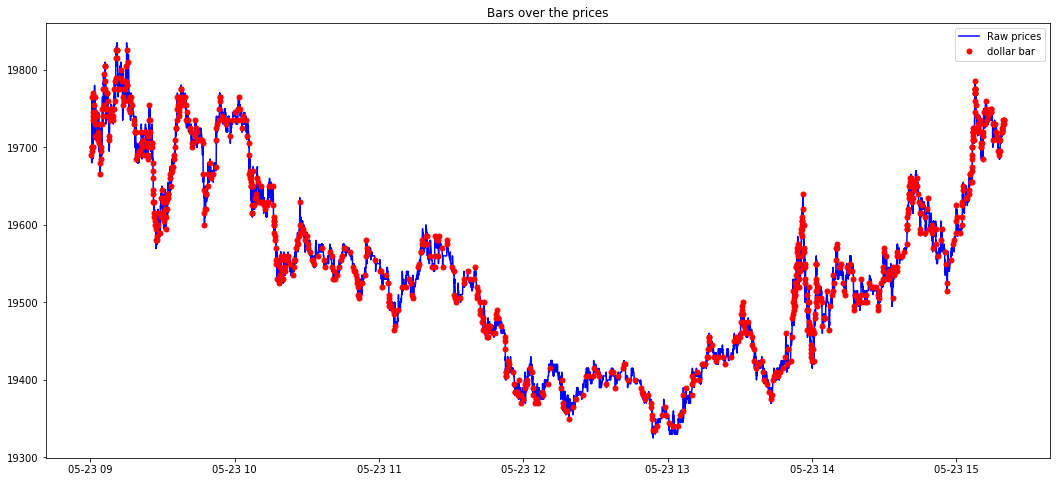

In [9]:
plot_bars(df_sub, dbar_sub, 'dollar bar')

## Apply triple barrier

In [10]:
diff = np.log(dbar['close']).diff()

In [11]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=dbar['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
daily_vol_mean = daily_vol.rolling(10000).mean()
cusum_events = ml.filters.cusum_filter(dbar['close'], daily_vol_mean=daily_vol_mean)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=dbar['close'], num_days=1)

Timestamp('2018-01-03 09:00:21.481000')


In [12]:
print(dbar.shape)
print(cusum_events.shape)
print(vertical_barriers.shape)

(518545, 5)
(28864,)
(28777,)


In [13]:
dbar.head()

,open,high,low,close,volume
date_time,,,,,
2018-01-02 10:00:03.348,19800.0,19980.0,19800.0,19980.0,216028
2018-01-02 10:00:03.349,19980.0,19985.0,19980.0,19985.0,8088
2018-01-02 10:00:04.614,19985.0,19990.0,19980.0,19990.0,6175
2018-01-02 10:00:06.841,19990.0,19995.0,19985.0,19990.0,7656
2018-01-02 10:00:10.929,19990.0,20000.0,19990.0,20000.0,8716


## Primary - Build Label

In [14]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=dbar['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers)

2019-06-03 09:39:57.971926 100.0% apply_pt_sl_on_t1 done after 0.1 minutes. Remaining 0.0 minutes.


In [15]:
labels_p = ml.labeling.get_bins(triple_barrier_events, dbar['close'])

In [16]:
labels_p.bin.value_counts()

-1    1727
 1    1679
 0     211
Name: bin, dtype: int64

## Primary - Features

In [17]:
raw_data = dbar.copy()

In [18]:
raw_data.head()

,open,high,low,close,volume
date_time,,,,,
2018-01-02 10:00:03.348,19800.0,19980.0,19800.0,19980.0,216028
2018-01-02 10:00:03.349,19980.0,19985.0,19980.0,19985.0,8088
2018-01-02 10:00:04.614,19985.0,19990.0,19980.0,19990.0,6175
2018-01-02 10:00:06.841,19990.0,19995.0,19985.0,19990.0,7656
2018-01-02 10:00:10.929,19990.0,20000.0,19990.0,20000.0,8716


In [19]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# fracdiff_FFD (Ch.05)
raw_data['fd_ffd'] = features.frac_diff_FFD(raw_data['log_ret'], 0.3, thres=1e-3)

# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Insert seq-bootstrap, sample weight, time decay here

In [20]:
# Sequential bootstrap
beg_date = dbar.index[0].date()
end_date = dbar.index[-1].date()

cur_bar_date = beg_date
step_day = 14
seq_phi_t1_idx = []
while cur_bar_date < end_date:
    cur_t1_date = cur_bar_date + datetime.timedelta(days=1)
    end_t1_date = cur_t1_date + datetime.timedelta(days=step_day)
    
    print("process {} - {}, total seq {}".format(cur_t1_date, end_t1_date, len(seq_phi_t1_idx)))
    sub_vbar = dbar.loc[cur_bar_date:end_t1_date]
    sub_t1 = triple_barrier_events.loc[cur_bar_date:end_t1_date]
    if len(sub_t1) == 0:
        print("len sub_t1 is zero")
        cur_bar_date += datetime.timedelta(days=step_day)
        continue
    bar_idx, t1 = sampling.get_baridx_t1(sub_vbar, sub_t1)
    
    
    ind_m = sampling.get_ind_matrix(bar_idx, t1)
    seq_phi = sampling.seq_bootstrap(ind_m, verbose=False)
    
    seq_phi_t1_idx += sub_t1.iloc[seq_phi].sort_index().loc[cur_t1_date:end_t1_date].index
    cur_bar_date += datetime.timedelta(days=step_day)
print(len(seq_phi_t1_idx))

385it [00:00, 7832.14it/s]

process 2018-01-03 - 2018-01-17, total seq 0



202it [00:00, 7024.59it/s]

process 2018-01-17 - 2018-01-31, total seq 385



459it [00:00, 7303.08it/s]

process 2018-01-31 - 2018-02-14, total seq 552



101it [00:00, 7782.78it/s]

process 2018-02-14 - 2018-02-28, total seq 993



55it [00:00, 6501.51it/s]

process 2018-02-28 - 2018-03-14, total seq 1092



157it [00:00, 6066.16it/s]

process 2018-03-14 - 2018-03-28, total seq 1143



94it [00:00, 5658.05it/s]

process 2018-03-28 - 2018-04-11, total seq 1294



35it [00:00, 5156.33it/s]

process 2018-04-11 - 2018-04-25, total seq 1368
process 2018-04-25 - 2018-05-09, total seq 1403



113it [00:00, 8327.73it/s]
222it [00:00, 7292.67it/s]

process 2018-05-09 - 2018-05-23, total seq 1500



133it [00:00, 7090.38it/s]

process 2018-05-23 - 2018-06-06, total seq 1711



82it [00:00, 7442.34it/s]

process 2018-06-06 - 2018-06-20, total seq 1844



204it [00:00, 8002.23it/s]

process 2018-06-20 - 2018-07-04, total seq 1910



153it [00:00, 7061.97it/s]

process 2018-07-04 - 2018-07-18, total seq 2093



169it [00:00, 7912.90it/s]

process 2018-07-18 - 2018-08-01, total seq 2206



124it [00:00, 7082.95it/s]

process 2018-08-01 - 2018-08-15, total seq 2375



131it [00:00, 6875.65it/s]

process 2018-08-15 - 2018-08-29, total seq 2476



65it [00:00, 6143.63it/s]

process 2018-08-29 - 2018-09-12, total seq 2591



21it [00:00, 6269.96it/s]
113it [00:00, 7877.48it/s]

process 2018-09-12 - 2018-09-26, total seq 2646
process 2018-09-26 - 2018-10-10, total seq 2664



112it [00:00, 6551.41it/s]

process 2018-10-10 - 2018-10-24, total seq 2777



292it [00:00, 9081.34it/s]

process 2018-10-24 - 2018-11-07, total seq 2889



194it [00:00, 7163.56it/s]

process 2018-11-07 - 2018-11-21, total seq 3181



84it [00:00, 4670.59it/s]

process 2018-11-21 - 2018-12-05, total seq 3353



119it [00:00, 6479.41it/s]

process 2018-12-05 - 2018-12-19, total seq 3426



95it [00:00, 7466.67it/s]

process 2018-12-19 - 2019-01-02, total seq 3534


3605


In [22]:
num_co_events = sampling.get_num_co_events(triple_barrier_events.index, t1=triple_barrier_events['t1'], num_threads=2)

2019-06-03 14:42:58.433974 100.0% mp_num_co_events done after 0.04 minutes. Remaining 0.0 minutes.


In [25]:
# sample weight and time decay
from finance_ml.sampling import time_weight, weight
wgt = sampling.get_sample_weight(np.log(dbar['close']).diff(), triple_barrier_events['t1'], num_co_events)
tw = sampling.get_uniq_weight(triple_barrier_events['t1'], num_co_events, num_threads=2)
td = sampling.get_time_decay(tw, last=0.5)
sample_weight = wgt[seq_phi_t1_idx] * td[seq_phi_t1_idx]

2019-06-03 14:47:33.062759 100.0% mp_uniq_weight done after 0.03 minutes. Remaining 0.0 minutes.


In [26]:
# Get features at event dates
X = raw_data.loc[seq_phi_t1_idx, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

y = labels_p.loc[seq_phi_t1_idx,'bin']

## Primary - Balance classes

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [28]:
# Split data into training, validation and test sets
X_training_validation = X['2018-01-01':'2018-10-31']
y_training_validation = y['2018-01-01':'2018-10-31']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [43]:
sample_weight.shape

(3605,)

In [42]:
sample_weight.loc[X_train.index].shape

(4596,)

In [29]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

 1    1189
-1    1182
 0     129
Name: bin, dtype: int64

In [31]:
# Create training data
y_train = train_df['bin']
X_train = train_df.loc[:, train_df.columns != 'bin']

## Primary - Fit a model

In [125]:
sw = []
for i in X_train.index:
    try:
        sw.append(sample_weight.loc[i].values[0])
    except:
        sw.append(sample_weight.loc[i])
print(len(sw))
sw_df = pd.DataFrame(sw, index=X_train.index)
sw_df.head()

2500


In [92]:
parameters = {'max_depth':[2, 4],
              'n_estimators':[2, 10],
              'random_state':[42]}

def perform_grid_search(X_data, y_data, _sw):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [93]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train, sw)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.4704 0.4996 0.478  0.4824]
10 2 42


In [128]:
# Refit a new model with best params, so we can see feature importance
rf1 = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf1.fit(X_train, y_train.values.ravel(), sw)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Primary - Training metrics

In [129]:
# Performance Metrics
y_pred_rf = rf1.predict_proba(X_train)[:, 1]
y_pred = rf1.predict(X_train)
x_side = y_pred
#fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

# plt.figure(1)
# plt.plot([-1, 1], [-1, 1], 'k--')
# plt.plot(fpr_rf, tpr_rf, label='RF')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

              precision    recall  f1-score   support

          -1       0.50      0.66      0.57      1182
           0       0.00      0.00      0.00       129
           1       0.53      0.41      0.46      1189

    accuracy                           0.51      2500
   macro avg       0.34      0.36      0.34      2500
weighted avg       0.49      0.51      0.49      2500

Confusion Matrix
[[783   0 399]
 [ 89   0  40]
 [702   0 487]]

Accuracy
0.508


/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Primary - Validation metrics

In [130]:
# Meta-label
# Performance Metrics
y_pred_rf = rf1.predict_proba(X_validate)[:, 1]
y_pred = rf1.predict(X_validate)
x_side = np.concatenate([x_side, y_pred])
# fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rf, tpr_rf, label='RF')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

              precision    recall  f1-score   support

          -1       0.55      0.70      0.62       338
           0       0.00      0.00      0.00        27
           1       0.41      0.30      0.35       260

    accuracy                           0.51       625
   macro avg       0.32      0.33      0.32       625
weighted avg       0.47      0.51      0.48       625

Confusion Matrix
[[238   0 100]
 [ 14   0  13]
 [182   0  78]]

Accuracy
0.5056


/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


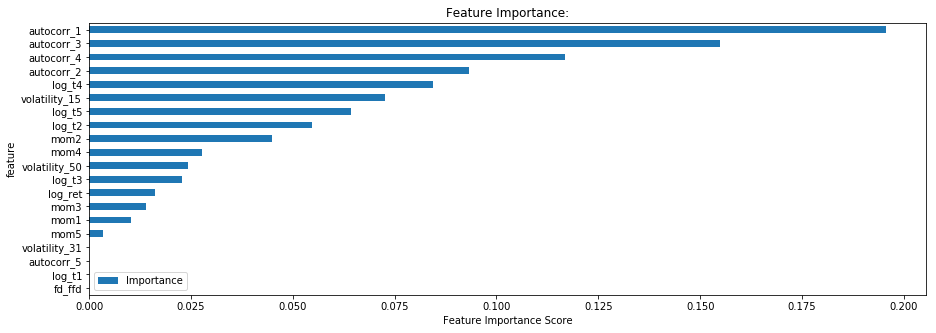

In [131]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf1.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

## Meta Labeling

In [132]:
dbar.head()

,open,high,low,close,volume
date_time,,,,,
2018-01-02 10:00:03.348,19800.0,19980.0,19800.0,19980.0,216028
2018-01-02 10:00:03.349,19980.0,19985.0,19980.0,19985.0,8088
2018-01-02 10:00:04.614,19985.0,19990.0,19980.0,19990.0,6175
2018-01-02 10:00:06.841,19990.0,19995.0,19985.0,19990.0,7656
2018-01-02 10:00:10.929,19990.0,20000.0,19990.0,20000.0,8716


In [133]:
raw_data = dbar.copy()

# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# fracdiff_FFD (Ch.05)
raw_data['fd_ffd'] = features.frac_diff_FFD(raw_data['log_ret'], 0.3, thres=1e-3)

# Remove look ahead bias
raw_data = raw_data.shift(1)

In [134]:
raw_data.head()

,open,high,low,close,volume,log_ret,mom1,mom2,mom3,mom4,...,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,fd_ffd
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-02 10:00:03.348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:00:03.349,19800.0,19980.0,19800.0,19980.0,216028.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:00:04.614,19980.0,19985.0,19980.0,19985.0,8088.0,0.00025,0.00025,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:00:06.841,19985.0,19990.0,19980.0,19990.0,6175.0,0.00025,0.00025,0.000501,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00025,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:00:10.929,19990.0,19995.0,19985.0,19990.0,7656.0,0.00000,0.00000,0.000250,0.000501,NaN,...,NaN,NaN,NaN,NaN,0.00025,0.00025,NaN,NaN,NaN,NaN


In [135]:
X = raw_data

X.dropna(inplace=True)

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

In [136]:
total_predict = rf1.predict(X)

In [137]:
total_predict.shape

(518478,)

In [138]:
dbar2 = dbar.loc[X.index]

In [139]:
dbar2['side'] = total_predict

In [140]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=dbar2['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=dbar2['side'])

2019-06-03 16:51:18.170033 100.0% apply_pt_sl_on_t1 done after 0.1 minutes. Remaining 0.0 minutes.


In [141]:
triple_barrier_events.head()

,side,t1,trgt
2018-01-09 09:01:09.291,-1.0,2018-01-09 09:02:53.717,0.005417
2018-01-09 09:01:32.046,-1.0,2018-01-09 09:02:38.938,0.005706
2018-01-09 09:02:03.804,1.0,2018-01-09 09:03:00.761,0.005768
2018-01-09 09:02:29.405,-1.0,2018-01-09 09:02:55.275,0.005546
2018-01-09 09:02:46.421,-1.0,2018-01-09 09:03:00.761,0.005789


In [142]:
labels_m = ml.labeling.get_bins(triple_barrier_events, dbar2['close'])
labels_m.side.value_counts()

-1.0    2257
 1.0    1358
Name: side, dtype: int64

In [143]:
labels_m.bin.value_counts()

1    2274
0    1341
Name: bin, dtype: int64

## Meta - Prepare training data

#### Insert seq-bootstrap, sample weight, time decay here

In [145]:
# Sequential bootstrap
beg_date = dbar.index[0].date()
end_date = dbar.index[-1].date()

cur_bar_date = beg_date
step_day = 14
seq_phi_t1_idx = []
while cur_bar_date < end_date:
    cur_t1_date = cur_bar_date + datetime.timedelta(days=1)
    end_t1_date = cur_t1_date + datetime.timedelta(days=step_day)
    
    print("process {} - {}, total seq {}".format(cur_t1_date, end_t1_date, len(seq_phi_t1_idx)))
    sub_vbar = dbar.loc[cur_bar_date:end_t1_date]
    sub_t1 = triple_barrier_events.loc[cur_bar_date:end_t1_date]
    if len(sub_t1) == 0:
        print("len sub_t1 is zero")
        cur_bar_date += datetime.timedelta(days=step_day)
        continue
    bar_idx, t1 = sampling.get_baridx_t1(sub_vbar, sub_t1)
    
    
    ind_m = sampling.get_ind_matrix(bar_idx, t1)
    seq_phi = sampling.seq_bootstrap(ind_m, verbose=False)
    
    seq_phi_t1_idx += sub_t1.iloc[seq_phi].sort_index().loc[cur_t1_date:end_t1_date].index
    cur_bar_date += datetime.timedelta(days=step_day)
print(len(seq_phi_t1_idx))

385it [00:00, 6918.71it/s]

process 2018-01-03 - 2018-01-17, total seq 0



0it [00:00, ?it/s]

process 2018-01-17 - 2018-01-31, total seq 385


202it [00:00, 5868.19it/s]
0it [00:00, ?it/s]

process 2018-01-31 - 2018-02-14, total seq 556


459it [00:00, 6710.77it/s]
101it [00:00, 6674.51it/s]

process 2018-02-14 - 2018-02-28, total seq 998



55it [00:00, 4364.69it/s]

process 2018-02-28 - 2018-03-14, total seq 1095



157it [00:00, 4638.67it/s]

process 2018-03-14 - 2018-03-28, total seq 1147



94it [00:00, 5437.31it/s]

process 2018-03-28 - 2018-04-11, total seq 1299



35it [00:00, 6615.92it/s]

process 2018-04-11 - 2018-04-25, total seq 1376



113it [00:00, 7469.88it/s]


process 2018-04-25 - 2018-05-09, total seq 1411


222it [00:00, 6686.55it/s]

process 2018-05-09 - 2018-05-23, total seq 1512



133it [00:00, 7894.63it/s]

process 2018-05-23 - 2018-06-06, total seq 1726



82it [00:00, 7926.73it/s]

process 2018-06-06 - 2018-06-20, total seq 1859



204it [00:00, 8541.60it/s]

process 2018-06-20 - 2018-07-04, total seq 1923



153it [00:00, 8238.17it/s]

process 2018-07-04 - 2018-07-18, total seq 2101



169it [00:00, 7208.69it/s]

process 2018-07-18 - 2018-08-01, total seq 2215



124it [00:00, 5953.32it/s]

process 2018-08-01 - 2018-08-15, total seq 2384



131it [00:00, 5389.71it/s]

process 2018-08-15 - 2018-08-29, total seq 2495



65it [00:00, 5382.20it/s]

process 2018-08-29 - 2018-09-12, total seq 2610



21it [00:00, 5106.41it/s]
0it [00:00, ?it/s]

process 2018-09-12 - 2018-09-26, total seq 2667
process 2018-09-26 - 2018-10-10, total seq 2685


113it [00:00, 7009.53it/s]
112it [00:00, 4930.28it/s]

process 2018-10-10 - 2018-10-24, total seq 2798



292it [00:00, 7133.17it/s]

process 2018-10-24 - 2018-11-07, total seq 2910



194it [00:00, 6603.92it/s]

process 2018-11-07 - 2018-11-21, total seq 3202



84it [00:00, 4684.19it/s]

process 2018-11-21 - 2018-12-05, total seq 3369



119it [00:00, 6373.75it/s]

process 2018-12-05 - 2018-12-19, total seq 3445



93it [00:00, 5555.77it/s]

process 2018-12-19 - 2019-01-02, total seq 3556
index -1 is out of bounds for axis 0 with size 0
Pandas(Index=Timestamp('2018-12-28 09:01:22.726000'), side=1.0, t1=NaT, trgt=0.019450620361773693)
index -1 is out of bounds for axis 0 with size 0
Pandas(Index=Timestamp('2018-12-28 09:01:52.550000'), side=1.0, t1=NaT, trgt=0.014945851190575073)


3627


In [146]:
# sample weight and time decay
from finance_ml.sampling import time_weight, weight
wgt = sampling.get_sample_weight(np.log(dbar['close']).diff(), triple_barrier_events['t1'], num_co_events)
tw = sampling.get_uniq_weight(triple_barrier_events['t1'], num_co_events, num_threads=2)
td = sampling.get_time_decay(tw, last=0.5)
sample_weight = wgt[seq_phi_t1_idx] * td[seq_phi_t1_idx]

2019-06-03 17:20:53.319683 100.0% mp_uniq_weight done after 0.03 minutes. Remaining 0.0 minutes.


In [148]:
# Get features at event dates
X = raw_data.loc[seq_phi_t1_idx, :]

# Drop unwanted columns
# X.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

y = labels_m.loc[seq_phi_t1_idx,'bin']

/mnt/afml/venv/lib/python3.5/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [149]:
y.value_counts()

1.0    2290
0.0    1335
Name: bin, dtype: int64

## Meta - Balance classes

In [150]:
# Split data into training, validation and test sets
X_training_validation = X['2018-01-01':'2018-10-31']
y_training_validation = y['2018-01-01':'2018-10-31']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [151]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

1.0    1576
0.0     951
Name: bin, dtype: int64

In [152]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

0.0    951
1.0    951
Name: bin, dtype: int64

In [153]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

## Meta - Fit a model

In [159]:
sw = []
for i in X_train.index:
    try:
        sw.append(sample_weight.loc[i].values[0])
    except:
        sw.append(sample_weight.loc[i])
print(len(sw))
sw_df = pd.DataFrame(sw, index=X_train.index)
sw_df.head()

1902


,0
2018-01-12 14:44:06.646,0.073599
2018-01-12 15:10:32.302,0.182876
2018-04-26 09:00:42.558,3.235184
2018-04-20 09:02:32.695,0.403732
2018-05-10 11:10:52.346,0.426529


In [154]:
parameters = {'max_depth':[2, 4],
              'n_estimators':[2, 10],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)    
    clf.fit(X_data, y_data)
    print(clf.cv_results_['mean_test_score'])    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [155]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.52418538 0.56571416 0.55507924 0.60648827]
10 4 42


In [163]:
sw_df.shape

(1902, 1)

In [164]:
# Refit a new model with best params, so we can see feature importance
rf2 = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf2.fit(X_train, y_train.values.ravel(), sw)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Meta - Training Metrics

              precision    recall  f1-score   support

         0.0       0.56      0.90      0.69       951
         1.0       0.73      0.28      0.41       951

    accuracy                           0.59      1902
   macro avg       0.64      0.59      0.55      1902
weighted avg       0.64      0.59      0.55      1902

Confusion Matrix
[[852  99]
 [681 270]]

Accuracy
0.5899053627760252


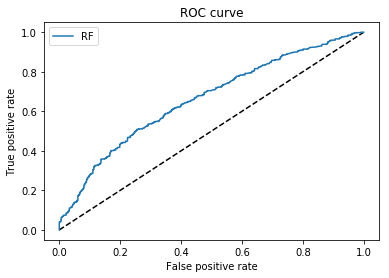

In [165]:
# Performance Metrics
y_pred_rf = rf2.predict_proba(X_train)[:, 1]
y_pred = rf2.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Meta - Validation Metrics

              precision    recall  f1-score   support

         0.0       0.34      0.79      0.48       210
         1.0       0.69      0.24      0.35       422

    accuracy                           0.42       632
   macro avg       0.52      0.51      0.41       632
weighted avg       0.58      0.42      0.39       632

Confusion Matrix
[[166  44]
 [322 100]]

Accuracy
0.4208860759493671


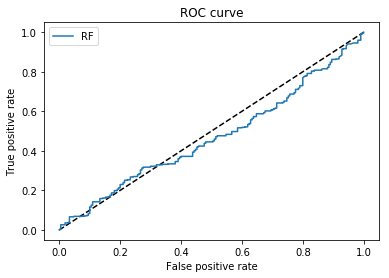

In [166]:
# Meta-label
# Performance Metrics
y_pred_rf = rf2.predict_proba(X_validate)[:, 1]
y_pred = rf2.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [167]:
print(X_validate.index.min())
print(X_validate.index.max())

2018-08-17 11:03:33.326000
2018-10-31 14:10:45.724000


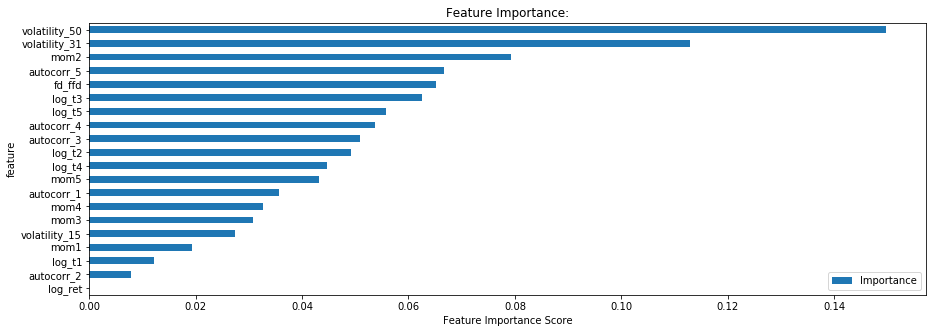

In [168]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf2.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

# Performance Tear Sheets (In-sample)

## Without Meta Labeling

In [169]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [170]:
y_pred = rf1.predict(X_validate)

valid_dates = X_validate.index
labels1 = labels_p.loc[valid_dates].copy()
labels2 = labels_p.loc[valid_dates].copy()
labels1.loc[labels1.loc[valid_dates, 'ret'].loc[y_pred!=1].index,'ret'] = 0
labels2.loc[labels2.loc[valid_dates, 'ret'].loc[y_pred!=-1].index,'ret'] = 0
primary_rets = labels1['ret'] - labels2['ret']
primary_model_rets = get_daily_returns(primary_rets)

In [171]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [172]:
# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

pf.show_perf_stats(primary_model_rets)

Start date,2018-08-20
End date,2018-10-31
Total months,2
,Backtest
Annual return,-49.3%
Cumulative returns,-13.3%
Annual volatility,56.7%
Sharpe ratio,-0.92
Calmar ratio,-2.43
Stability,0.76
Max drawdown,-20.3%


### With Meta Labeling

In [173]:
y_pred = rf2.predict(X_validate)
meta_returns = primary_rets * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

In [174]:
# Save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

pf.show_perf_stats(daily_meta_rets)

Start date,2018-08-20
End date,2018-10-31
Total months,2
,Backtest
Annual return,-42.0%
Cumulative returns,-10.8%
Annual volatility,19.3%
Sharpe ratio,-2.73
Calmar ratio,-3.33
Stability,0.62
Max drawdown,-12.6%


---
## Perform out-of-sample test
### Meta Model Metrics

In [192]:
# Extarct data for out-of-sample (OOS)
X_oos = X['2018-11-01':]
y_oos = y['2018-11-01':]
labels_oos = labels_m['2018-11-01':]

In [200]:
y_oos = y_oos.loc[~y_oos.index.duplicated(keep='first')].dropna()
X_oos = X_oos.loc[~X_oos.index.duplicated(keep='first')].loc[y_oos.index]
labels_oos = labels_oos.loc[~labels_oos.index.duplicated(keep='first')].loc[y_oos.index]

/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       117
         1.0       0.65      0.39      0.49       198

    accuracy                           0.24       315
   macro avg       0.22      0.13      0.16       315
weighted avg       0.41      0.24      0.31       315

Confusion Matrix
[[  0   0   0]
 [ 75   0  42]
 [121   0  77]]

Accuracy
0.24444444444444444


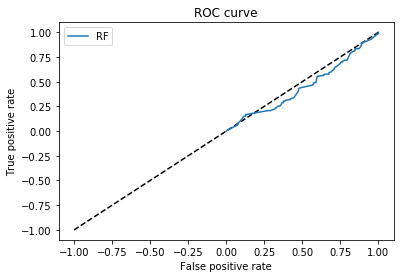

In [201]:
# Primary model
y_pred_rf = rf1.predict_proba(X_oos)[:, 1]
y_pred = rf1.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([-1, 1], [-1, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

         0.0       0.37      0.80      0.51       117
         1.0       0.62      0.19      0.29       198

    accuracy                           0.42       315
   macro avg       0.49      0.50      0.40       315
weighted avg       0.52      0.42      0.37       315

Confusion Matrix
[[ 94  23]
 [161  37]]

Accuracy
0.4158730158730159


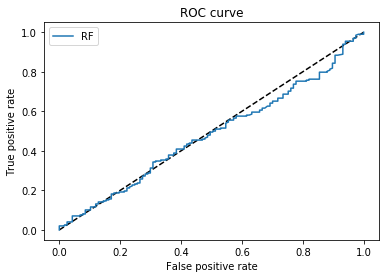

In [202]:
# Performance Metrics
y_pred_rf = rf2.predict_proba(X_oos)[:, 1]
y_pred = rf2.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Primary Model (Test Data)

In [203]:
test_dates = X_oos.index

# Downsample to daily
y_pred = rf1.predict(X_oos)
labels1 = labels_oos.copy()
labels2 = labels_oos.copy()
labels1.loc[labels1.loc[test_dates, 'ret'].loc[y_pred!=1].index,'ret'] = 0
labels2.loc[labels2.loc[test_dates, 'ret'].loc[y_pred!=-1].index,'ret'] = 0
primary_rets = labels1['ret'] - labels2['ret']
daily_rets_prim = get_daily_returns(primary_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=daily_rets_prim, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model OOS'] = perf_stats_all

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(daily_rets_prim)

Start date,2018-11-02
End date,2018-12-28
Total months,1
,Backtest
Annual return,285.2%
Cumulative returns,24.5%
Annual volatility,158.0%
Sharpe ratio,1.63
Calmar ratio,8.48
Stability,0.41
Max drawdown,-33.6%


## Meta Model (Test Data)

Start date,2018-11-02
End date,2018-12-28
Total months,1
,Backtest
Annual return,284.6%
Cumulative returns,24.5%
Annual volatility,48.7%
Sharpe ratio,3.02
Calmar ratio,25.37
Stability,0.68
Max drawdown,-11.2%


/mnt/afml/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.22,2018-12-06,2018-12-17,2018-12-26,15
1,9.04,2018-12-26,2018-12-27,NaT,NaN
2,2.33,2018-11-05,2018-11-08,2018-11-14,8
3,0.53,2018-11-28,2018-11-29,2018-11-30,3
4,0.00,2018-11-02,2018-11-02,2018-11-02,1


/mnt/afml/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


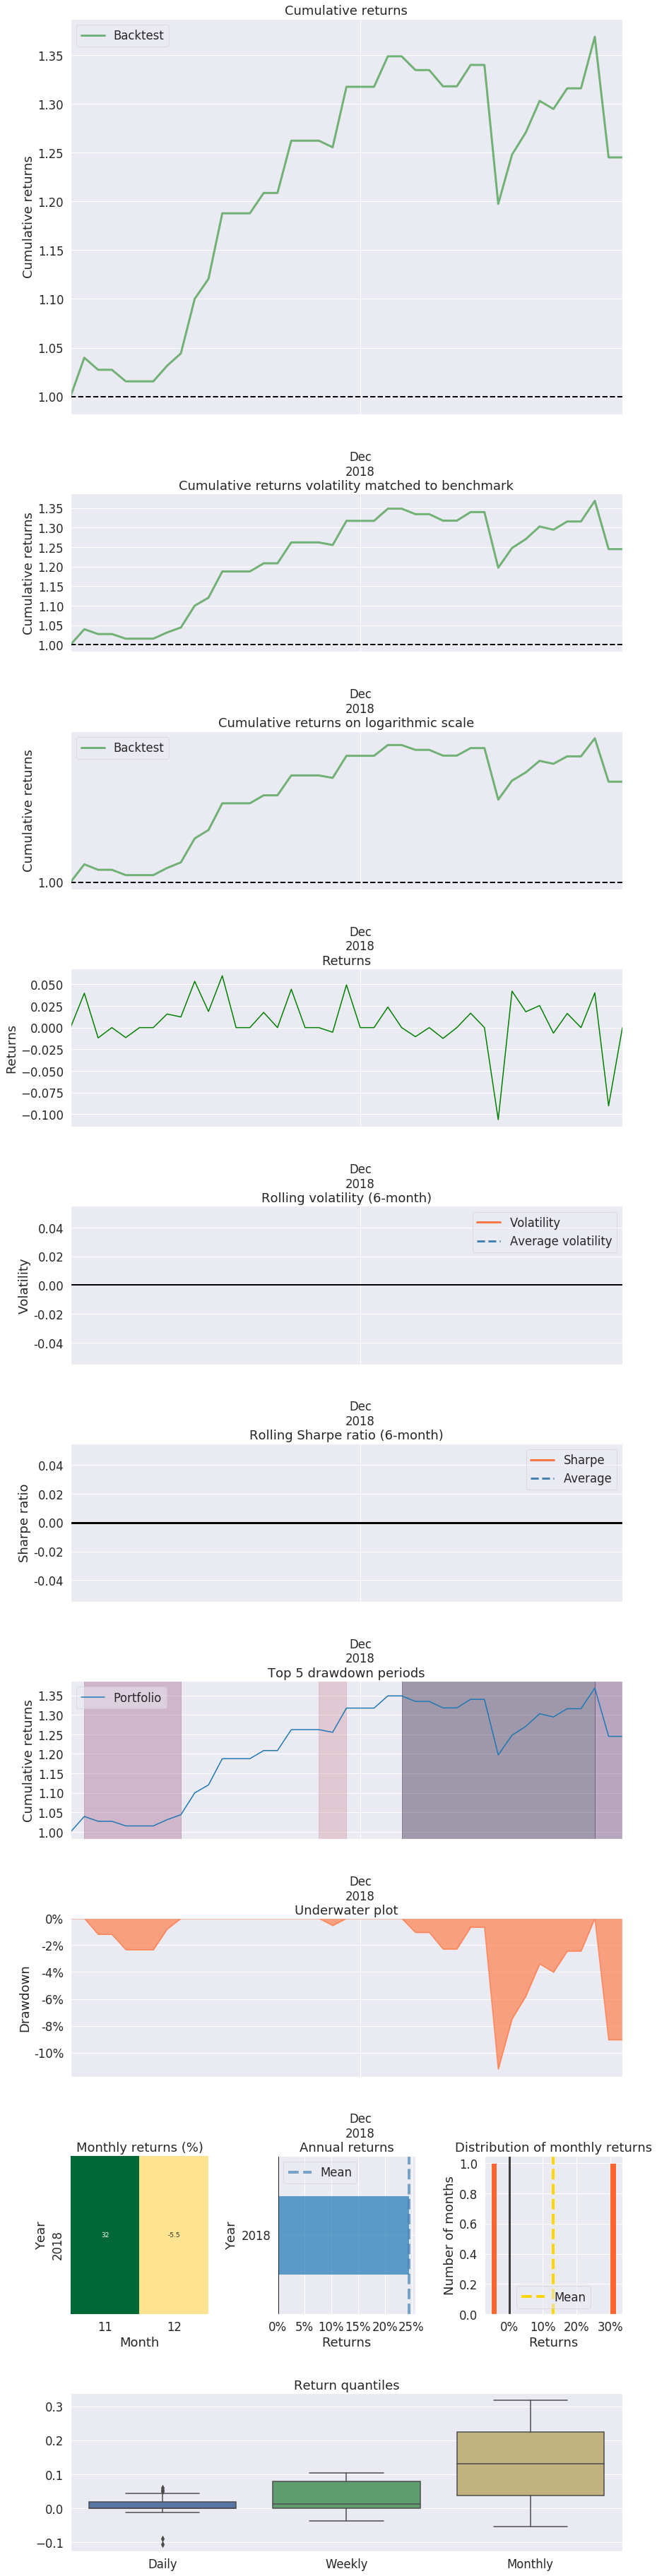

In [204]:
y_pred = rf2.predict(X_oos)
meta_returns = primary_rets * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)